## B&S simple classical generator

This file can be used to reproduce Figure 4 of the manuscript

Where we train a generator state $\vert \psi_G \rangle = \sum_i c_i \vert i \rangle$ with trainable parameters $c_i$ together with a quantum discriminator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

import jax
from jax import numpy as jnp
import optax

from functools import partial
from flax.training import train_state 
from src.Bars_and_Stripes_Loader import BASDataset, NumpyLoader
from src.Jax_Circuit_helper import circuit_to_execute_D, Full_Model, get_percentage_of_samples, get_percentage_of_dataset

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


## Define all Variables

In [2]:
image_size = 2  # Height / width of the square images
batch_size = 4 # Batch size 

n_work = 4  # Number of qubits used for data encoding
auxiliary_D = 0  # Nr of auxiliary qubits for discriminator
auxiliary_G = 0  # Nr of auxiliary for the generator (set to zero for the classical psi_G)
n_total = n_work + auxiliary_D
depth_D = 20 # depth of D

n_critic = 5 # number of D updates until G update
lrG = 0.01  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 10001  # Number of training iterations

shots = 20 # we only need samples during training to visualize progress. Nr of shots not relevant

n_samples = 10000 # nr of samples for histogram per noise

seed = 1 # random seed
key = jax.random.PRNGKey(seed) # initialize pseudo random number generator
_, subkey = jax.random.split(key)

## Load Dataset

In [3]:
dataset = BASDataset(transform=None, size=(image_size, image_size))
dataloader = NumpyLoader(dataset, batch_size=batch_size, shuffle=True)

## Define the pennylane Qnodes

We define the quantum discriminator and the full model which takes an input state $\vert \psi_G \rangle$ and inputs it into the discriminator.

In [4]:
dev = qml.device("default.qubit.jax", wires=n_work + auxiliary_D)
dev_sample = qml.device("default.qubit.jax", wires=n_work + auxiliary_D, shots = shots, prng_key=subkey)
dev_total = qml.device("default.qubit.jax", wires=n_work+auxiliary_D)

discriminator = qml.QNode(partial(circuit_to_execute_D, depth_D=depth_D, 
                                  n_work = n_work, 
                                  auxiliary_D = auxiliary_D), 
                          dev_total, interface = "jax", diff_method="backprop")

full_model = qml.QNode(partial(Full_Model, depth_D=depth_D,
                               n_work = n_work, 
                               auxiliary_D = auxiliary_D, auxiliary_G = auxiliary_G), 
                       dev, interface = "jax", diff_method="backprop")

D_vmap = jax.vmap(discriminator, in_axes=(0, None))
full_model_vmap = jax.vmap(full_model, in_axes=(0, None))

## Define Train States and Training Loop

In [5]:
def create_train_state_G(subkey, learning_rate):
    """Creates initial `TrainState` for the state_G"""
    psi_G = jax.random.uniform(subkey, (1, 2**n_work), dtype = np.float32)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=D_vmap, params=psi_G, tx=tx) # there is no apply_fn, D_vmap is just a dummy

def create_train_state_circuit(subkey, learning_rate):
    """Creates initial `TrainState` for the discriminator circuit"""
    weights_D = jax.random.uniform(subkey, (depth_D , (n_work + auxiliary_D), 3), dtype = np.float32)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=D_vmap, params=weights_D, tx=tx)


@jax.jit
def train_step_D(state_D, state_G, data):
    def pred_real(weights_D, data):
        pred = D_vmap(data, weights_D)
        pred = (pred+1.)/2.
        return pred.mean()

    def pred_fake(psi_G, weights_D):
        pred = full_model_vmap(psi_G, weights_D)
        pred = (pred+1.)/2
        return pred.mean()

    def W_loss_D(psi_G, weights_D, data):
        pred_f = pred_fake(psi_G, weights_D)
        pred_r = pred_real(weights_D, data)
        return pred_f - pred_r
    
    grad_fn = jax.value_and_grad(W_loss_D, argnums = 1)
    loss, grads = grad_fn(state_G.params, state_D.params, data)
    state_D = state_D.apply_gradients(grads=grads)
    return state_D, loss

@jax.jit
def train_step_G(state_D, state_G):
    def pred_fake(psi_G, weights_D):
        pred = full_model_vmap(psi_G, weights_D)
        pred = (pred+1.)/2
        return pred.mean()

    def W_loss_G(params_NN, weights_D):
        pred_f = pred_fake(params_NN, weights_D)
        return -pred_f
    
    grad_fn = jax.value_and_grad(W_loss_G, argnums = 0)
    loss, grads = grad_fn(state_G.params, state_D.params)
    state_G = state_G.apply_gradients(grads=grads)
    return state_G, loss

def train_run(state_D, state_G, subkey, num_iter):
    history_D = []
    history_G = []
    for i in range(num_iter):    
        _, (data, _) = next(enumerate(dataloader))
        data = data.reshape(-1, image_size * image_size)
        _, subkey = jax.random.split(subkey)

        state_D, lossD = train_step_D(state_D, state_G, data)
        history_D.append(lossD.item())
        
        if i%n_critic == 0 and i!= 0:
            state_G, lossG = train_step_G(state_D, state_G)
            history_G.append(lossG.item())
        
        if i % 100 == 0 and i!=0:
            print(f'Iteration: {i}, Discriminator Loss: {lossD:0.3f}, Generator Loss: {lossG:0.3f}')
    return state_D, state_G, history_G, history_D

## Run Training

In [6]:
jax_state_G = create_train_state_G(subkey, lrG)
jax_state_D = create_train_state_circuit(subkey, lrD)
state_D, state_G, history_G, history_D = train_run(jax_state_D, jax_state_G, subkey, num_iter)

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/autoray/autoray.py:348: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)


Iteration: 100, Discriminator Loss: -0.899, Generator Loss: -0.017
Iteration: 200, Discriminator Loss: -0.842, Generator Loss: -0.011
Iteration: 300, Discriminator Loss: -0.882, Generator Loss: -0.009
Iteration: 400, Discriminator Loss: -0.816, Generator Loss: -0.015
Iteration: 500, Discriminator Loss: -0.828, Generator Loss: -0.006
Iteration: 600, Discriminator Loss: -0.890, Generator Loss: -0.005
Iteration: 700, Discriminator Loss: -0.782, Generator Loss: -0.003
Iteration: 800, Discriminator Loss: -0.878, Generator Loss: -0.006
Iteration: 900, Discriminator Loss: -0.779, Generator Loss: -0.001
Iteration: 1000, Discriminator Loss: -0.843, Generator Loss: -0.006
Iteration: 1100, Discriminator Loss: -0.874, Generator Loss: -0.005
Iteration: 1200, Discriminator Loss: -0.844, Generator Loss: -0.003
Iteration: 1300, Discriminator Loss: -0.776, Generator Loss: -0.006
Iteration: 1400, Discriminator Loss: -0.828, Generator Loss: -0.002
Iteration: 1500, Discriminator Loss: -0.872, Generator Lo

/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/autoray/autoray.py:348: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
/Users/patrickhuembeli/anaconda3/envs/TNandJAX/lib/python3.9/site-packages/pennylane/_qubit_device.py:652: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return (states_sampled_base_ten > 0).astype(dtype)[:, ::-1]


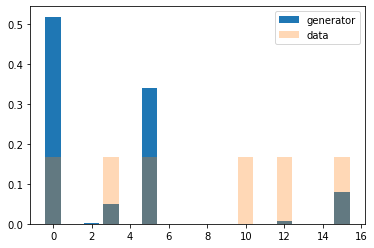

In [7]:
full_dataset = dataset.df
percentage = get_percentage_of_samples(state_G.params, subkey, n_samples, n_work, auxiliary_G = 0)
percentage2 = get_percentage_of_dataset(full_dataset.reshape(-1, 4), n_work)
plt.bar(range(2**n_work), percentage, label="generator")
plt.bar(range(2**n_work), percentage2, label="data", alpha = 0.3)
plt.legend()
plt.show()

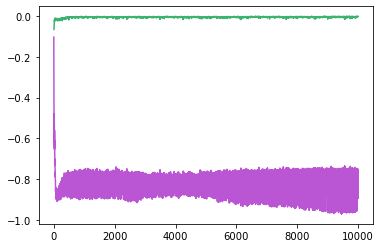

In [8]:
plt.plot(range(num_iter), history_D, label = "loss D", color = "mediumorchid")
plt.plot(range(n_critic, num_iter, n_critic), history_G, label = "loss G", color = "mediumseagreen")